# Introduction

Consider a general nonlinear partial differential equation with $d$ spatial dimensions and 1 time dimension:


\begin{align} 
\frac{\partial u}{\partial t}(t, x)+\mathcal{L} u(t, x)=0, \quad && (t, x) \in[0, T] \times \Omega \\ 
 u(0, x)=u_0(x), u(T, x)=u_T(x),  \quad &&x \in \Omega \\ 
 \mathcal{G}(u(t, x), \mathcal{L} u(t, x))=g(t, x), \quad &&(t, x) \in [0, T] \times \partial \Omega 
 \end{align}


where $\Omega  \subset \mathbb{R}^d$ is the spatial domain and $\partial \Omega$ is the boundary of domain $\Omega$. 


There are several cases of $\mathcal{G}$, leading to different types of boundary conditions. As follows are three prominent cases

1. Dirichlet boundary conditions: $\mathcal{G}(u(t, x), \mathcal{L} u(t, x)) = \mathcal{G}_1( u(t, x))$.
2. Neumann boundary conditions: $\mathcal{G}(u(t, x), \mathcal{L} u(t, x)) = \mathcal{G}_2(\mathcal{L} u(t, x))$
3. Robin boundary conditions: $\mathcal{G}(u(t, x), \mathcal{L} u(t, x)) = \mathcal{G}_1( u(t, x)) + \mathcal{G}_2(\mathcal{L} u(t, x))$


# Methodology

The method construct a neural network for approximating solution to the nonlinear partial differential equation, as

$$
u_\theta(t,x) \approx u(t,x)
$$

where $u_\theta :[0,T] \times \mathcal{D} \to \mathbb{R}$ denotes a function realized by a neural network with parameters $\theta$.

To set a goal for the algorithm, we construct loss function

\begin{equation}
\begin{aligned}
        J(u) & =\left\|\frac{\partial u}{\partial t}(t, x ; \Theta)+\mathcal{L} u(t, x ; \Theta)\right\|_{[0, T] \times \Omega, \nu_1}^2\\
        &+\left\|u(0, x ; \Theta)-u_0(x)\right\|_{\Omega, \nu_2}^2+\left\|u(T, x ; \Theta)-u_T(x)\right\|_{\Omega, \nu_3}^2\\
        &+\|\mathcal{G}(u(t, x ; \Theta), \mathcal{L} u(t, x ; \Theta))-g(t, x)\|_{[0, T] \times \partial \Omega, \nu_4}^2
\end{aligned}
\end{equation}

To approximate the $\mathcal{L}^2$ norm, we sample points from state space $[0, T] \times \Omega$ and compute mean squared error as 

\begin{equation*}
        \begin{aligned}
            &\frac{1}{|D^1|}\sum_{(t_m,x_m) \in D^1}\left(\frac{\partial u}{\partial t}\left(t_m, x_m ; \Theta_n\right) +\mathcal{L} u\left(t_m, x_m ; \Theta_n\right)\right)^2\\
            &+\frac{1}{|D^2|}\sum_{y_q \in D^2}\left(u\left(0, y_q ; \Theta_n\right)-u_0\left(y_q\right)\right)^2+\frac{1}{|D^3|}\sum_{z_k \in D^3}\left(u\left(T, z_k ; \Theta_n\right)-u_T\left(z_k\right)\right)^2\\
            &+\frac{1}{|D^4|}\sum_{(t_p,x_p) \in D^4}\left(\mathcal{G}(u\left(\tau_p, w_p ; \Theta_n\right), \mathcal{L} u\left(\tau_p, w_p ; \Theta_n\right))-g\left(\tau_p, w_p\right)\right)^2\\
        \end{aligned}
    \end{equation*}

where 

1. $D^1=\{(t_m,x_m)\}_{m=1}^M$ from state space $[0,T] \times \Omega$
2. $D^2=\{y_q\}_{q=1}^Q,D^3=\{z_k\}_{k=1}^K$ from $\Omega$ 
3. $D^4=\{(\tau_p,w_p)\}_{p=1}^P$ from state space $[0,T] \times \partial \Omega$

# Example Aiyagari Model with Poisson Income Process

\begin{aligned}
& \rho v_1(a)=\max _c u(c)+v_1^{\prime}(a)\left(z_1+r a-c\right)+\lambda_1\left(v_2(a)-v_1(a)\right) \\
& \rho v_2(a)=\max _c u(c)+v_2^{\prime}(a)\left(z_2+r a-c\right)+\lambda_2\left(v_1(a)-v_2(a)\right)
\end{aligned}

## 1. Load Necessary Package and Problem-Specific Parameter



In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Aiyagari problem parameters
gamma = 2
r = 0.03
rho = 0.05
Var = 0.07
Corr = 0.9
the = -np.log(Corr)
sig2 = 2*the*Var

z1 = .1
z2 = .2
z = np.array([z1, z2])
la1 = 0.02
la2 = 0.03
la = np.array([la1, la2])

eps = tf.constant(1e-10, dtype=tf.float32)

X_low = np.array([-0.02])  # wealth lower bound
X_high = np.array([2])          # wealth upper bound



def u(c):
    return c**(1-gamma)/(1-gamma)


def u_deriv(c):
    return c**(-gamma)


def u_deriv_inv(c):
    return c**(-1/gamma)


## 2. Define Network Structure by Class

In [16]:
# Define model architecture
class DCGMNet(tf.keras.Model):
    """ Set basic architecture of the model."""

    def __init__(self, X_low, X_high,
                 input_dim, output_dim,
                 n_layers_FFNN, layer_width,
                 activation_FFNN,
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)
        
        self.X_low = X_low
        self.X_high = X_high
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.n_layers_FFNN = n_layers_FFNN
        self.layer_width = layer_width
        
        self.activation_FFNN = activation_FFNN
        # print(activation_FFNN)
        
        # Define NN architecture
        self.initial_scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - X_low)/(X_high - X_low) - 1.0)
        self.hidden = [tf.keras.layers.Dense(layer_width,
                                             activation=tf.keras.activations.get(
                                                 activation_FFNN),
                                             kernel_initializer=kernel_initializer)
                       for _ in range(self.n_layers_FFNN)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.initial_scale(X)
        for i in range(self.n_layers_FFNN):
            Z = self.hidden[i](Z) +Z
        return self.out(Z)


# neural network parameters
num_layers_FFNN = 4
num_layers_RNN = 0
nodes_per_layer = 50
starting_learning_rate = 0.001
shrinkstep = 20000
shrinkcoef = 0.95
activation_FFNN = 'tanh'
# Training parameters
sampling_stages  = 6000   # number of times to resample new time-space domain points
steps_per_sample = 10    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 128
nSim_boundary = 1

dim_input = 1
dim_output = 2
 
model = DCGMNet(X_low, X_high,  
                 dim_input, dim_output, 
                 num_layers_FFNN, nodes_per_layer,
                 activation_FFNN)


## 3. Construct Loss Function and Sampling Function

In [17]:

def sampler(nSim_interior, nSim_boundary):
    ''' Sample space points from the function's domain
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at boundary to sample 
    ''' 
    
    # Sampler #1: domain interior    

    X_interior = tf.random.uniform(
        shape=[nSim_interior, 1], minval=X_low, maxval=X_high, dtype=tf.float32)


    a_alower = X_low[0] * tf.ones(shape = (nSim_boundary, 1), dtype=tf.float32)
    X_alower = a_alower

    return X_interior, X_alower


def loss_differentialoperator(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_a = tf.math.maximum(eps*tf.ones_like(V), V_a)


    c = u_deriv_inv(V_a)
    u_c = u(c) 
    
    diff_V_z1 = -rho * V[:, 0] + u_c[:, 0] + V_a[:, 0] * (z[0]+r*a[:, 0]-c[:, 0]) + la[0] * (V[:, 1] - V[:, 0])
    diff_V_z2 = -rho * V[:, 1] + u_c[:, 1] + V_a[:,1] * (z[1]+r*a[:,0]-c[:,1]) + la[1]* (V[:,0] - V[:,1])

    diff_V = tf.concat([diff_V_z1,diff_V_z2], axis=0)
        
    L = tf.reduce_mean(tf.square(diff_V))
    return diff_V, L

def loss_differentialoperator_alower(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_a = tf.math.maximum( tf.zeros_like(V), V_a)
    V_a_new = tf.math.maximum(u_deriv(z+ r* a), V_a)

    c_new = u_deriv_inv(V_a_new)
    u_c_new = u(c_new) 
    

    diff_V_z1 = -rho * V[:,0] + u_c_new[:,0] + V_a[:,0]*(z[0]+r*a[:,0]-c_new[:,0]) + la[0]* (V[:,1] - V[:,0])
    diff_V_z2 = -rho * V[:,1] + u_c_new[:,1] + V_a[:,1]*(z[1]+r*a[:,0]-c_new[:,1]) + la[1]* (V[:,0] - V[:,1])

    diff_V = tf.concat([diff_V_z1,diff_V_z2], axis=0)
        

    L = tf.reduce_mean(tf.square(diff_V))
    return diff_V, L

def loss_concave(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_aa = tf.concat([tf.gradients(V_a[:,0], a)[0],tf.gradients(V_a[:,1], a)[0]],axis=1)
    concave_V = tf.maximum(V_aa, tf.zeros_like(V))

    L = tf.reduce_mean( tf.square(concave_V ) )
    return L


def compute_loss(model, X_interior, X_alower):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        X_interior, X_alower:      Points

    ''' 

    Loss_V_interior, L1 = loss_differentialoperator(model, X_interior)

    Loss_V_alower, L2 = loss_differentialoperator_alower(model, X_alower)
    
    L3 =  loss_concave(model, X_interior)

    L = L1 + L2 + L3 
    
    return L
    
    
def get_grad(model, X_interior, X_alower):
    
    with tf.GradientTape(persistent=True) as tape:

        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_interior, X_alower)

    grad = tape.gradient(loss, model.trainable_variables)
    del tape
    
    return loss, grad


## 4. Train the neural network

Takes 2 minute to finish training on Mac M1 chip.

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=starting_learning_rate)
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=starting_learning_rate)




@tf.function
def train_step(X_interior, X_alower):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_interior, X_alower)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss


hist = []

for i in range(sampling_stages):

    # sample uniformly from the required regions

    X_interior, X_alower = sampler(nSim_interior, nSim_boundary)

    for _ in range(steps_per_sample):
        loss = train_step(X_interior, X_alower)
    
    hist.append(loss.numpy())
    
    if i%100==0:
        tf.print("Progress: {}/{}, Loss: {}".format(i,sampling_stages,loss))
    

Progress: 0/6000, Loss: 63.720298767089844
Progress: 100/6000, Loss: 1.9996236562728882
Progress: 200/6000, Loss: 0.104180708527565
Progress: 300/6000, Loss: 0.031488340348005295
Progress: 400/6000, Loss: 0.01761266402900219
Progress: 500/6000, Loss: 0.03179439529776573
Progress: 600/6000, Loss: 0.01939237304031849
Progress: 700/6000, Loss: 0.0016709500923752785
Progress: 800/6000, Loss: 0.017475232481956482
Progress: 900/6000, Loss: 0.0002026314614340663
Progress: 1000/6000, Loss: 8.255224383901805e-05
Progress: 1100/6000, Loss: 2.8810482035623863e-05
Progress: 1200/6000, Loss: 6.0260943428147584e-05
Progress: 1300/6000, Loss: 1.6900143236853182e-05
Progress: 1400/6000, Loss: 2.2162541426951066e-05
Progress: 1500/6000, Loss: 3.922088217223063e-05
Progress: 1600/6000, Loss: 3.552173438947648e-05
Progress: 1700/6000, Loss: 1.6123503883136436e-05
Progress: 1800/6000, Loss: 2.9111824915162288e-06
Progress: 1900/6000, Loss: 3.592337179725291e-06
Progress: 2000/6000, Loss: 3.428953277762048

Text(0.5, 1.0, 'Saving')

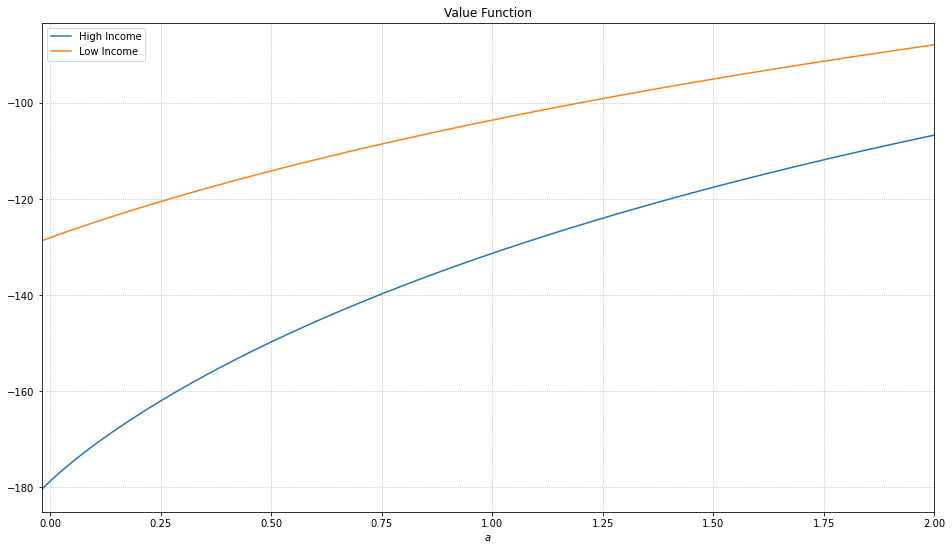

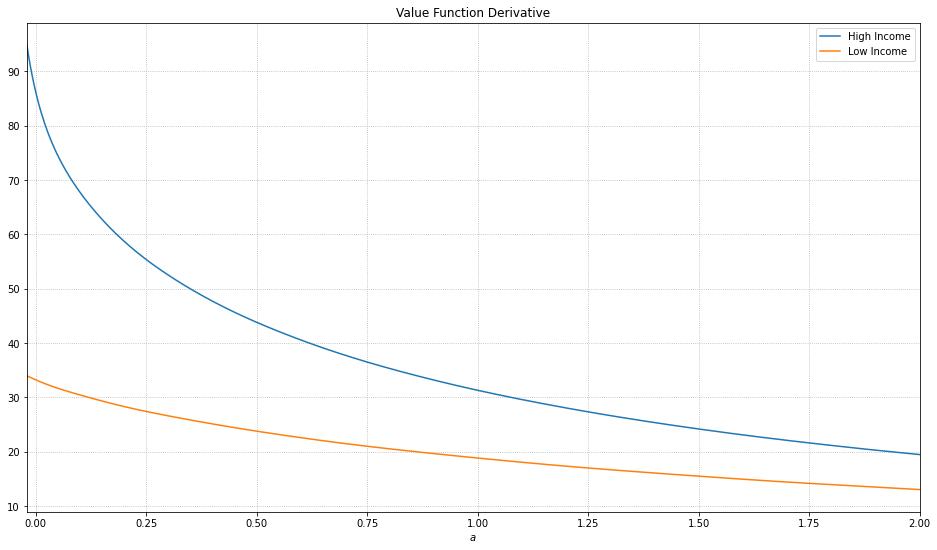

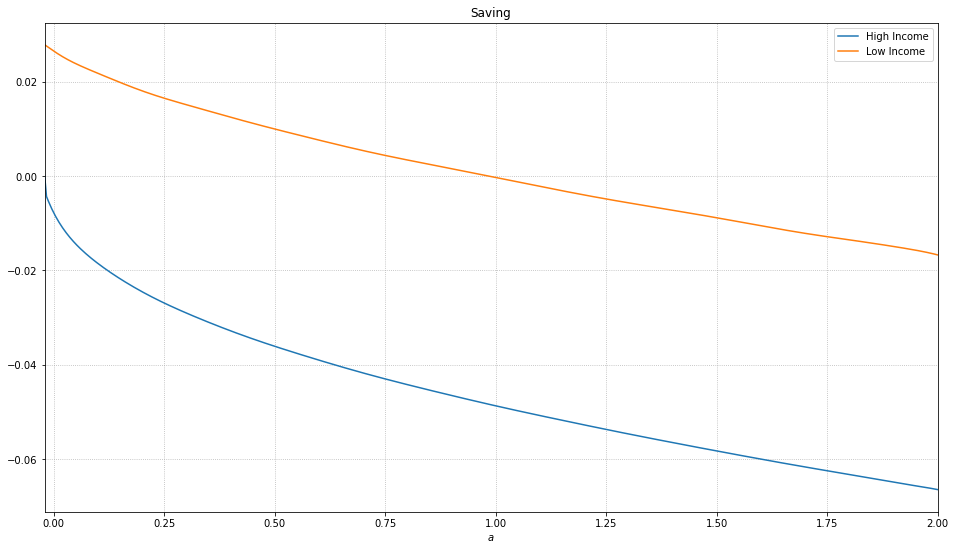

In [19]:
aspace = np.linspace(X_low, X_high, 500)
# A = np.meshgrid(aspace)
A = aspace
X_interior = np.vstack([A.flatten()]).T

X_alower = np.vstack([A[A==X_low].flatten()]).T


with tf.GradientTape(persistent=True) as tape:
    a = tf.cast(X_interior, dtype=tf.float32)[:,0:1]
    tape.watch(a)
    V = model(tf.stack([a[:, 0]], axis=1))
    Va_1 = tape.gradient(V[:,0], a)
    Va_2 = tape.gradient(V[:, 1], a)
    Va = tf.concat([Va_1,Va_2],axis=1)

fitted_V = V.numpy().reshape(500, 2)
fitted_Va = Va.numpy().reshape(500,2)
fitted_saving = z+r*X_interior - u_deriv_inv(fitted_Va)

fitted_saving[0,:] = np.maximum(fitted_saving[0,:], np.zeros_like(fitted_saving[0,:]))

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_V[:, 0], label="High Income")
plt.plot(X_interior[:, 0], fitted_V[:, 1], label="Low Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low, X_high)
plt.title("Value Function")

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_Va[:, 0], label="High Income")
plt.plot(X_interior[:, 0], fitted_Va[:, 1], label="Low Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low, X_high)
plt.title("Value Function Derivative")

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_saving[:, 0], label="High Income")
plt.plot(X_interior[:, 0], fitted_saving[:, 1], label="Low Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low,X_high)
plt.title("Saving")
